In [1]:
#import necessary libraries
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re


C:\Users\polir\AppData\Local\Temp\ipykernel_18628\2265695912.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(r'train.csv',encoding= 'latin1')

In [3]:
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
df.tail()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054,128900.0,81
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523,340.0,331
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568,107160.0,167
27479,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral,morning,0-20,Guinea,13132795,246000.0,53


In [5]:
df.shape

(27480, 10)

In [6]:
df.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],
      dtype='object')

In [7]:
#print the unique value of sentiment data
print('The unique numbers in the sentiment data are as follow :')
df.nunique()

The unique numbers in the sentiment data are as follow :


textID              27480
text                27479
selected_text       22429
sentiment               3
Time of Tweet           3
Age of User             6
Country               195
Population -2020      195
Land Area (Km²)       193
Density (P/Km²)       136
dtype: int64

In [8]:
df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [9]:
df.dtypes

textID               object
text                 object
selected_text        object
sentiment            object
Time of Tweet        object
Age of User          object
Country              object
Population -2020      int64
Land Area (Km²)     float64
Density (P/Km²)       int64
dtype: object

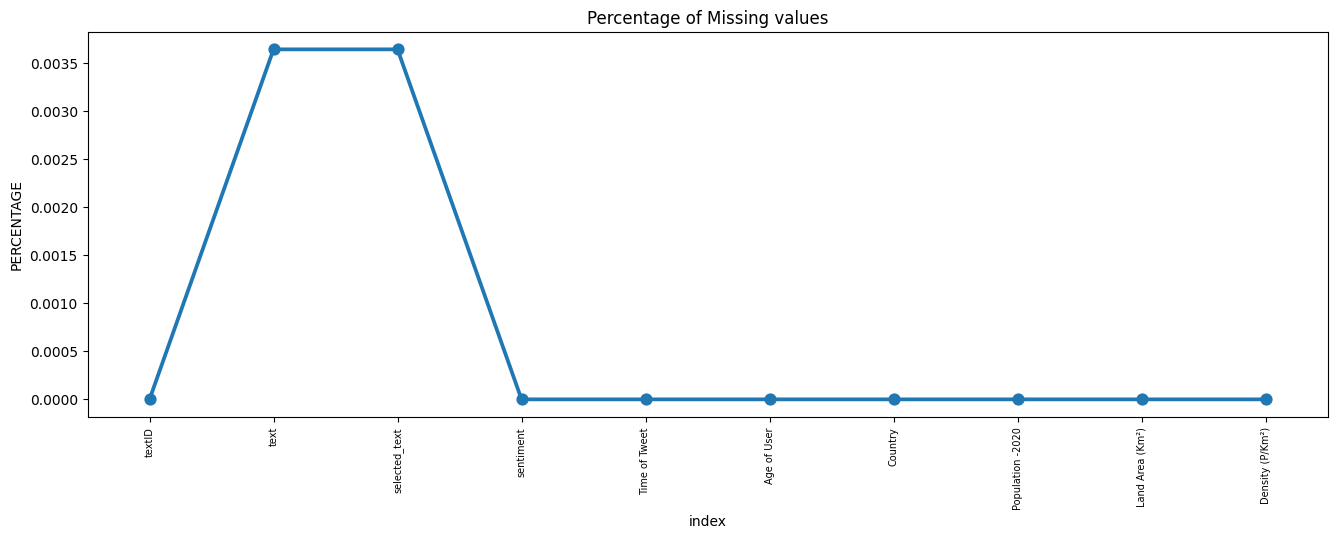

In [10]:
#plot the graph to check wether there are any missing value present
missing = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index',y=0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

In [11]:
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [13]:
df = df[['text', 'sentiment']]

In [14]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [15]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [16]:
df.sentiment.value_counts()

sentiment
neutral     11117
positive     8581
negative     7781
Name: count, dtype: int64

In [17]:
def text_clean(text): 
    # changing to lower case
    lower = text.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039,!*;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [18]:
df['text_clean'] = text_clean(df['text'])

In [19]:
df.head()

,text,sentiment,text_clean
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going"
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!
2,my boss is bullying me...,negative,my boss is bullying me...
3,what interview! leave me alone,negative,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t...",negative,"sons of ****, why couldn`t they put them on t..."


In [20]:
df = df[['text_clean','sentiment']]

In [21]:
df.head()

,text_clean,sentiment
0,"i`d have responded, if i were going",neutral
1,sooo sad i will miss you here in san diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"sons of ****, why couldn`t they put them on t...",negative


In [22]:
df.tail()

,text_clean,sentiment
27475,wish we could come see u on denver husband l...,negative
27476,i`ve wondered about rake to. the client has ...,negative
27477,yay good for both of you. enjoy the break - y...,positive
27478,but it was worth it ****.,positive
27479,all this flirting going on - the atg smiles...,neutral


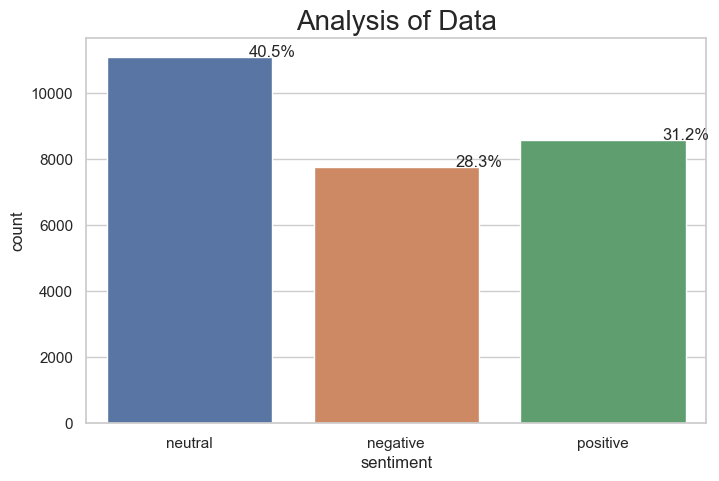

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(df))
ax = sns.countplot(x="sentiment", hue="sentiment", data=df)
plt.title('Analysis of Data', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [24]:
df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8581
negative     7781
Name: count, dtype: int64

In [35]:
df = df[:5000]


In [36]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [37]:
df.head()

,text_clean,sentiment
0,"i`d have responded, if i were going",1
1,sooo sad i will miss you here in san diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"sons of ****, why couldn`t they put them on t...",0


In [38]:
df.shape

(5000, 2)

In [39]:
x = df['text_clean']
y= df['sentiment']

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.3, random_state=101)

In [41]:
from sklearn.feature_extraction.text import HashingVectorizer
hvectorizer = HashingVectorizer(n_features=10000,norm=None,alternate_sign=False,stop_words='english') 
x_train = hvectorizer.fit_transform(x_train).toarray()
x_test = hvectorizer.transform(x_test).toarray()

In [42]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
y_train

3601    1
4896    0
2702    0
2432    1
2177    2
       ..
918     1
3598    0
1118    0
1121    0
2728    0
Name: sentiment, Length: 3500, dtype: int64

In [44]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)
acc_dt = accuracy_score(y_test,y_pred)
print(acc_dt)

0.5713333333333334


In [45]:
import pickle
filename = 'decision.sav'
pickle.dump(dt, open(filename, 'wb'))

In [46]:
model = pickle.load(open(filename, 'rb'))

In [47]:
pre_dt=precision_score(y_pred,y_test,pos_label='positive',average='micro')
print(pre_dt)

0.5713333333333334


C:\Users\polir\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [48]:
re_dt=recall_score(y_pred,y_test,pos_label='positive',average='micro')
print(re_dt)

0.5713333333333334


C:\Users\polir\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [49]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(x_train[:1000],y_train[:1000])
y_pred=rf.predict(x_test)
acc_rf=accuracy_score(y_pred,y_test)
acc_rf

0.5853333333333334

In [50]:
import pickle
filename = 'randomforest.sav'
pickle.dump(dt, open(filename, 'wb'))

In [51]:
model = pickle.load(open(filename, 'rb'))

In [52]:
pre_rf=precision_score(y_pred,y_test,pos_label='positive',average='micro')
print(pre_rf)

0.5853333333333334


C:\Users\polir\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [53]:
re_rf=recall_score(y_pred,y_test,pos_label='positive',average='micro')
print(re_rf)

0.5853333333333334


C:\Users\polir\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# training the model
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
acc_lr = accuracy_score(y_test,y_pred)
acc_lr

0.6053333333333333

In [55]:
import pickle
filename = 'logistic.sav'
pickle.dump(dt, open(filename, 'wb'))

In [56]:
model = pickle.load(open(filename, 'rb'))

In [57]:
pre_lr=precision_score(y_pred,y_test,pos_label='positive',average='micro')
print(pre_lr)

0.6053333333333333


C:\Users\polir\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [58]:
re_lr=recall_score(y_pred,y_test,pos_label='positive',average='micro')
print(re_lr)

0.6053333333333333


C:\Users\polir\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

rfs = RandomForestClassifier(random_state=42)
dts = DecisionTreeClassifier(random_state=42)
lrs = LogisticRegression(random_state=42)
meta = LogisticRegression(random_state=42)
# Define the stacking classifier pipeline
base_classifiers = [('rfs', rfs), ('dts', dts)]
stacking_classifier = make_pipeline(
    StandardScaler(),
    # Predict the class probabilities for the base classifiers using cross-validation
    # and use them as features for the meta-classifier
    StackingClassifier(estimators=base_classifiers, final_estimator=lr, cv=5)
)

# Train the stacking classifier on the training set
stacking_classifier.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = stacking_classifier.predict(x_test)

# Evaluate the accuracy of the stacking classifier
acc_stack = accuracy_score(y_test, y_pred)
print(acc_stack)

In [ ]:
import pickle
filename = 'hybrid.sav'
pickle.dump(dt, open(filename, 'wb'))

In [ ]:
model = pickle.load(open(filename, 'rb'))

In [59]:
# Now tokenizing the text column    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text_clean'].values)
X = tokenizer.texts_to_sequences(df['text_clean'].values)
X = pad_sequences(X)
X[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,  146,   19,   74,    1,  147,   40],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  369,  116,    1,   55,   93,    7,   95,   12, 1154, 1663]])

In [60]:
#Hereby I declare the train and test dataset.
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4000, 33) (4000, 3)
(1000, 33) (1000, 3)


In [61]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 128)           256000    
                                                                 
 spatial_dropout1d (Spatial  (None, 33, 128)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 511391 (1.95 MB)
Trainable params: 511391 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [62]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15


32/32 [==============================] - 8s 163ms/step - loss: 1.0836 - accuracy: 0.4060
Epoch 2/15
32/32 [==============================] - 5s 147ms/step - loss: 0.9914 - accuracy: 0.5035
Epoch 3/15
32/32 [==============================] - 5s 145ms/step - loss: 0.8135 - accuracy: 0.6450
Epoch 4/15
32/32 [==============================] - 5s 143ms/step - loss: 0.6743 - accuracy: 0.7105
Epoch 5/15
32/32 [==============================] - 4s 139ms/step - loss: 0.5775 - accuracy: 0.7602
Epoch 6/15
32/32 [==============================] - 5s 145ms/step - loss: 0.5097 - accuracy: 0.7960
Epoch 7/15
32/32 [==============================] - 5s 142ms/step - loss: 0.4567 - accuracy: 0.8142
Epoch 8/15
32/32 [==============================] - 5s 144ms/step - loss: 0.4204 - accuracy: 0.8353
Epoch 9/15
32/32 [==============================] - 4s 139ms/step - loss: 0.3951 - accuracy: 0.8505
Epoch 10/15
32/32 [==============================] - 5s 141ms/step - loss: 0.3352 - accuracy: 0.87

In [63]:
from tensorflow.keras.models import Model

In [64]:
final_model= Model.save(model,"lstm.h5")

C:\Users\polir\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
df["sentiment"].value_counts()

sentiment
1    2023
2    1592
0    1385
Name: count, dtype: int64

In [66]:
df = df[['text_clean','sentiment']]

In [67]:
df1 = df[df['sentiment'] != 'neutral']

In [68]:
# split the data into train and test sets
train, test = train_test_split(df1, test_size=0.3, random_state=42)

In [69]:
train.shape, test.shape

((3500, 2), (1500, 2))

In [70]:
train.sentiment.value_counts()

sentiment
1    1398
2    1117
0     985
Name: count, dtype: int64

In [71]:
test.sentiment.value_counts()

sentiment
1    625
2    475
0    400
Name: count, dtype: int64

In [73]:
X_train = train.text_clean.tolist()
X_test = test.text_clean.tolist()

y_train = train.sentiment.tolist()
y_test = test.sentiment.tolist()

data = pd.concat([train,test], ignore_index=True)

class_names = ['negative','neutral', 'positive']

print('size of training set: %s' % (len(train['text_clean'])))
print('size of validation set: %s' % (len(test['text_clean'])))
print(data.sentiment.value_counts())

data.head(10)

size of training set: 3500
size of validation set: 1500
sentiment
1    2023
2    1592
0    1385
Name: count, dtype: int64


,text_clean,sentiment
0,lakers tomorrow kb and df ftw!,1
1,"no! i would like this! yesterday, i talked wi...",2
2,has had a wonderful day with some gorgeous gir...,2
3,http://twitpic.com/4wgoi - at bus boys and poe...,1
4,wow the weather is amazing today!,2
5,i love to! but i`m only available from 5pm. ...,2
6,hope schools gonna be good tomorrow,2
7,i wanna go to the borgata tonight if rich is p...,1
8,all this talk of buttershots has me wanting so...,1
9,net .. net .. net .. hmm. bad weather .. weir...,0


In [ ]:
! pip install ktrain

In [ ]:
import ktrain
from ktrain import text

In [ ]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350, 
                                                                       max_features=35000)

In [ ]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

In [ ]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)

In [ ]:


learner.fit_onecycle(2e-5, 2)

In [ ]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

In [ ]:
import time 

message = "Hello ?"

start_time = time.time() 
prediction = predictor.predict(message)

print('predicted: {} ({:.2f})'.format(prediction, (time.time() - start_time)))

In [ ]:
predictor.save("bert_model.h5")

In [ ]:
plt.plot(learner.history.history['accuracy'],'r')
plt.plot(learner.history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(r"\bert_acc.png")
plt.show()

In [ ]:
plt.plot(learner.history.history['loss'],'r')
plt.plot(learner.history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(r"\bert_loss.png")
plt.show()

In [ ]:
result = dt.predict(hvectorizer.transform(['''i d have responded if i were going''']))
if result==0:
    print("It's a negative statement")
elif result==1:
    print("It's a neutral statement")
else:
    print("It's a positive statement")

In [ ]:
# Now tokenizing the text column    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text_clean'].values)
X = tokenizer.texts_to_sequences(df['text_clean'].values)
X = pad_sequences(X)
X[:2]

In [ ]:
#Hereby I declare the train and test dataset.
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [ ]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 1)

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
final_model= Model.save(model,"lstm.h5")